In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)

# Data

The data object contains the time-bins and observed counts in the individual energy channels. It can also be used to rebin the data in new, longer, time bins.

In [2]:
from gbmbkgpy.data.gbm_data import GBMData
# get daily GBM data
gbmdata = GBMData(name="gbmn0", 
                date="200510", 
                data_type="ctime", 
                detector="n6", 
                echans=["1","2","3-5"])

# Rebin the data to 20 second bins
gbmdata.rebin_data(min_bin_width=20)

Plot counts in effective echan 0 as function of time

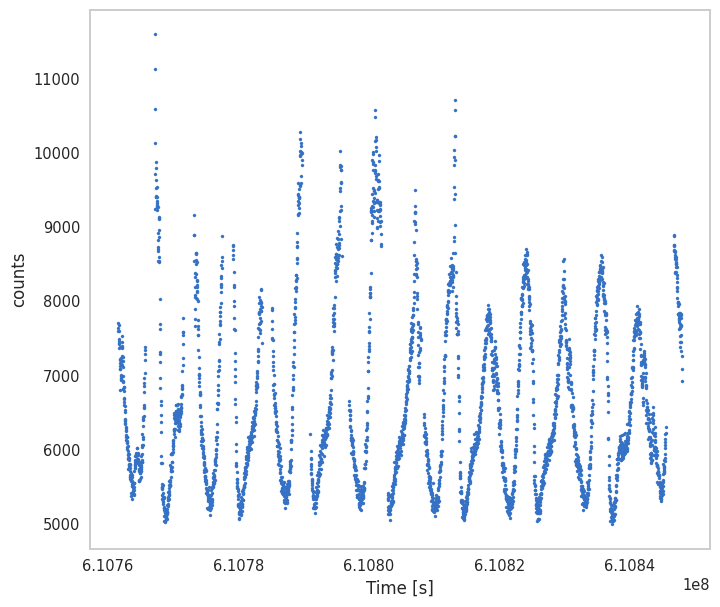

In [3]:
plt.scatter(gbmdata.mean_time, gbmdata.counts[:, 0], s=5)
plt.ylabel("counts")
plt.xlabel("Time [s]");

# Geometry

The data object contains the information how to transform a position in icrs coords (ra and dec) to the satellite coordinate system (az and el) (and the opposite way) for any given time. It also needs a method that returns if a given position in icrs coordinates is occulted by the earth at a given time.

In [4]:
from gbmbkgpy.geometry.gbm_geometry import GBMGeometryPosHist

# init geometry object for Fermi/GBM at the given date
geom = GBMGeometryPosHist(date="200510")

Transform icrs to satellite frame

In [5]:
time = round(gbmdata.mean_time[100])
ra = [50, 100, 150, 200, 250]
dec = [0, 0, 0, 0, 0]
az, el = geom.icrs_to_satellite(time, ra, dec)
for (a, e, r, d) in zip(az, el, ra, dec):
    print(f"ICRS ({r}, {d}) -> Satellite ({a}, {e})")

ICRS (50, 0) -> Satellite (356.87197857243024, 21.23785882753735)
ICRS (100, 0) -> Satellite (44.47341520675653, 2.3454518134180518)
ICRS (150, 0) -> Satellite (90.85021846482132, -18.03688027053613)
ICRS (200, 0) -> Satellite (144.45989469628742, -26.038559910551513)
ICRS (250, 0) -> Satellite (196.78964907441872, -14.756252285976089)


Check if some points are occulted by the earth at a certain time

In [6]:
time = round(gbmdata.mean_time[100])
ra = [50, 100, 150, 200, 250]
dec = [0, 0, 0, 0, 0]
occ = geom.is_occulted(time, ra, dec)
for (o, r, d) in zip(occ, ra, dec):
    if o:
        print(f"ICRS ({r}, {d}) is occulted by earth at time {time} s")
    else:
        print(f"ICRS ({r}, {d}) is not occulted by earth at time {time} s")

ICRS (50, 0) is not occulted by earth at time 610763637 s
ICRS (100, 0) is not occulted by earth at time 610763637 s
ICRS (150, 0) is not occulted by earth at time 610763637 s
ICRS (200, 0) is occulted by earth at time 610763637 s
ICRS (250, 0) is occulted by earth at time 610763637 s


# Response

The response generator object can generate a response for any given position in icrs or satellite frame.

In [7]:
from gbmbkgpy.response.gbm_response import GBMResponseGenerator

# General response Generator
drm_gen = GBMResponseGenerator(geometry=geom, Ebins_in_edge=np.geomspace(10,2000, 101), data=gbmdata)

Generate the response for some test positions

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/responsum-1.0.2-py3.9.egg/responsum/response.py:108: RuntimeWarning: Minimum MC energy (10.0) is larger than minimum EBOUNDS energy (5.307523250579834)


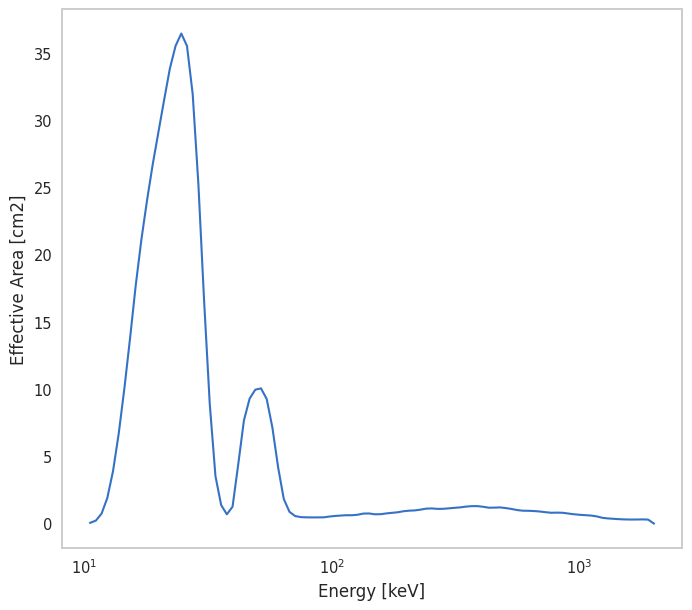

In [8]:
time = round(gbmdata.mean_time[100])
ra = 200
dec = 50
mat = drm_gen.calc_response_ra_dec(ra, dec, time, occult=False)

# Eff. Area for different incoming energies to be detected in eff echan 0
plt.plot(drm_gen.Ebins_in_edge[1:], mat[:,0])
plt.xscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel("Effective Area [cm2]");

For the extended sources we need to pre-calculate the response on a spherical grid around the detector. These responses get weighted later to account for the spatial extension of the source. In this case we use 10000 grid points. The more points we use the longer the pre-calculation takes.

In [9]:
from gbmbkgpy.response.response_precalculation import ResponsePrecalculation

# Response precalculation for extended sources.
rsp_pre = ResponsePrecalculation(drm_gen, Ngrid=10000)

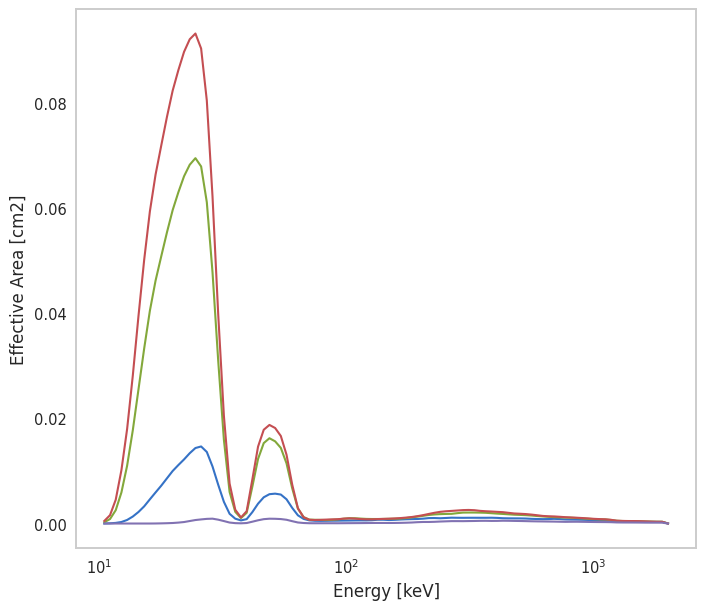

In [10]:
# Eff. Area for different incoming energies to be detected in eff echan 0 for a few grid points
plt.plot(drm_gen.Ebins_in_edge[1:], rsp_pre.response_grid[100, :,0])
plt.plot(drm_gen.Ebins_in_edge[1:], rsp_pre.response_grid[500, :,0])
plt.plot(drm_gen.Ebins_in_edge[1:], rsp_pre.response_grid[1000, :,0])
plt.plot(drm_gen.Ebins_in_edge[1:], rsp_pre.response_grid[5000, :,0])
plt.xscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel("Effective Area [cm2]");

Pre-calculate the effective responses for extended sources

In [11]:
from gbmbkgpy.response.src_response import EarthResponse, CGBResponse, GalacticCenterResponse

# Time where to calculate the effective responses - linear interpolation in between
interp_time = np.linspace(gbmdata.time_bins[0,0], gbmdata.time_bins[-1,-1], 800)

# Galactic Center
gc_rsp = GalacticCenterResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre)

# Earth Albedo
earth_rsp = EarthResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre)

# CGB
cgb_rsp = CGBResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre)

Response for a point source

In [12]:
from gbmbkgpy.response.src_response import PointSourceResponse

# Response for Crab
crab_rsp = PointSourceResponse(response_generator=drm_gen, interp_times=interp_time, ra=83.633, dec=22.015)

# Modelling

Here we first construct the different sources contributing to the background. The source can be split in two classes: PhotonSources that we can forward fold through the response (very good!) and particle sources that we can not forward fold due to the lack of a charged particle response or similar (not very good). The particle sources we therefore have to model directly in count space.

Let's start with the photon sources. We have to different kind of photon sources: PhotonSourceFixed and PhotonSourceFree. The difference is only important if we want to fit the background, because for PhotonSourceFixed sources only the normalization is free but for PhotonSourceFree also the spectral parameters are free. Here the Crab and the CGB sources are defines and we use the PhotonSourceFixed to keep it simple for this example, as in this case only the normalization is free, while the spectral parameters are fixed.

We use astromodels as the spectral modeling framework.

In [13]:
from gbmbkgpy.modeling.source import PhotonSourceFixed
from astromodels import Powerlaw
from gbmbkgpy.modeling.new_astromodels import SBPL

from astromodels.utils.configuration import astromodels_config
astromodels_config.modeling.ignore_parameter_bounds = True

# A point source

# Define spectrum
pl_crab = Powerlaw()
pl_crab.K.value = 9.7
pl_crab.index.value = -2.1

# define source
crab = PhotonSourceFixed("Crab", pl_crab, crab_rsp)


# extended source

#CGB
# values taken from Ajello et al. 2008
cgb_spec = SBPL()
cgb_spec.K.value = 0.11
cgb_spec.alpha.value = 1.32
cgb_spec.beta.value = 2.88
cgb_spec.xb.value = 30.0

# define source
cgb = PhotonSourceFixed("CGB", cgb_spec, cgb_rsp)

/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


After we set the time bins we can plot what the sources would look like in our data space.

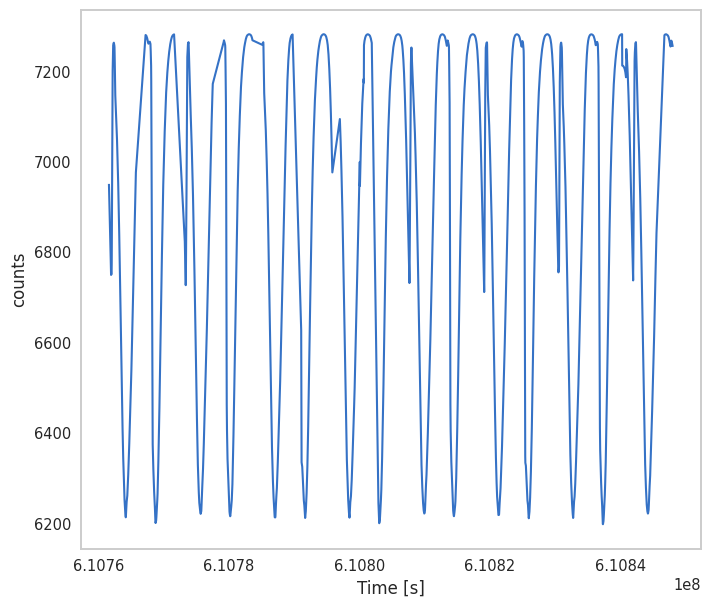

In [14]:
cgb.set_time_bins(gbmdata.time_bins)

plt.plot(gbmdata.mean_time, cgb.get_counts()[:,0])
plt.ylabel("counts")
plt.xlabel("Time [s]");

Next the particle sources. For the cosmic rays we use a cosmic ray tracer from the geometry object (McIlwain L-parameter at the satellite position) and the SAAs are modelled as exponetial decay. These source are modelled directly in count data space and we have no information how to connect the individual energy channels. Therefore we model it independent in every energy channel with the use of the AstromodelFunctionVector wrapper, that just copies the base_function for every energy channel.

In [15]:
from gbmbkgpy.modeling.functions import AstromodelFunctionVector
from gbmbkgpy.modeling.source import SAASource, NormOnlySource

from astromodels import Exponential_cutoff, Constant
from astromodels import Log_uniform_prior, Uniform_prior

# SAA
exp_decay = Exponential_cutoff()
exp_decay.K.value = 1000
exp_decay.xc.value = 1000
exp_decay.K.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=10000)
exp_decay.xc.prior = Uniform_prior(lower_bound=0.001, upper_bound=10000)
afv_saa = AstromodelFunctionVector(gbmdata.num_echan, base_function=exp_decay)

# define the time when the satellite leaves the SAA
exit_time_saa = gbmdata.mean_time[100]

saa = SAASource("SAA", exit_time_saa, afv_saa)

# CR
c = Constant()
c.k.value = 100
c.k.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=1000)
afv_cr = AstromodelFunctionVector(gbmdata.num_echan, base_function=c)

cr = NormOnlySource("CR", geom.cr_tracer, afv_cr)

# Constant
c = Constant()
c.k.value = 100
c.k.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=1000)
afv_cons = AstromodelFunctionVector(gbmdata.num_echan, base_function=c)
  
def f(x):
  return np.ones_like(x)
  
cons = NormOnlySource(f"Constant", f, afv_cons)

Again after we set the time bins we can plot what the sources would look like in our data space.

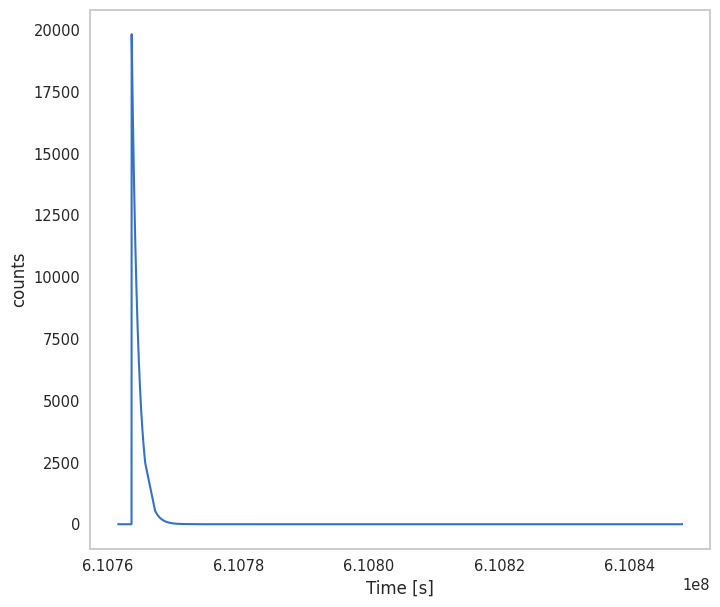

In [16]:
saa.set_time_bins(gbmdata.time_bins)

plt.plot(gbmdata.mean_time, saa.get_counts()[:,0])
plt.ylabel("counts")
plt.xlabel("Time [s]");

Now we can create the model object that connects the sources with the data. This can be used to plot the total model against the data or also calculate the log_like of the current model configuration.

In [17]:
from gbmbkgpy.modeling.model import ModelDet

model = ModelDet(gbmdata)

model.add_source(cgb)
model.add_source(crab)

model.add_source(saa)
model.add_source(cr)
model.add_source(cons)

# Fitting

Fitting the model to the data is now very simple. The standard fitting algorithm in gbmbkgpy is [MultiNest](https://github.com/farhanferoz/MultiNest), via the Python interface [PyMultiNest](https://github.com/JohannesBuchner/PyMultiNest). As we are doing a Bayesian Analysis here, we first have to set the priors for all model parameters. For Cosmic Rays and SAA these were already set when the sources were created.

In [18]:
cgb.fit_model.k.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=100)
crab.fit_model.k.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=100)

Starting the fit now is only one line of code, in which we specify the name of the fit (for the resulting files from MultiNest) and the number of live points for MultiNest:

In [19]:
model.minimize_multinest(identifier="test_fit", n_live_points=400, verbose=False)

 *****************************************************
 MultiNest v3.12
 Copyright Farhan Feroz & Mike Hobson
 Release Nov 2019

 no. of live points =  400
 dimensionality =   14
 *****************************************************



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.


  analysing data from /home/runner/GBMDATA/fits/mn_out/test_fit_05-12_11-57/fit_.txt ln(ev)=   530402731.14333856      +/-  0.70711801955439468     
 Total Likelihood Evaluations:       208479
 Sampling finished. Exiting MultiNest



# Plotting

Now we can plot the fitted model with the data for a given effective energy channel:

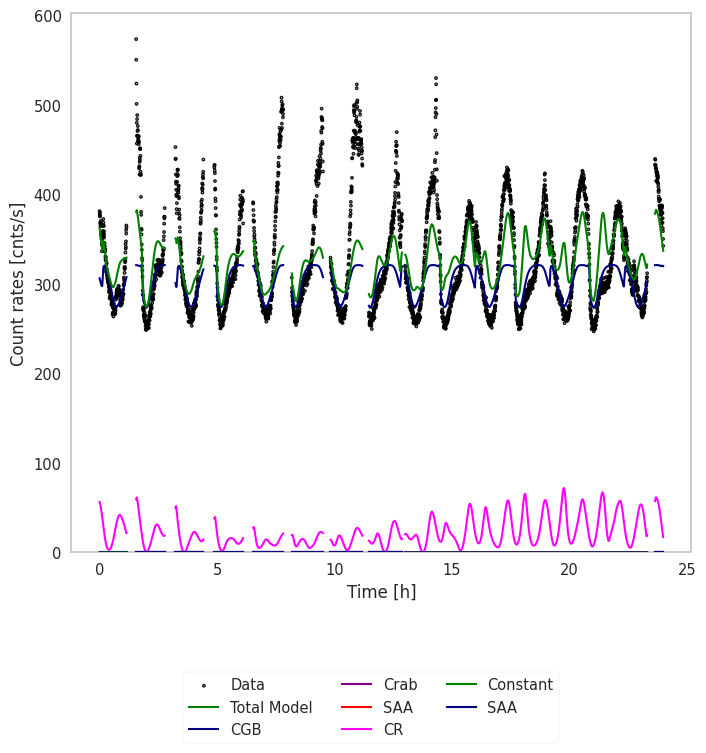

In [20]:
from gbmbkgpy.io.plotting.plot import plot_lightcurve
ax = plot_lightcurve(model, show_data=True, eff_echan=0, model_component_list=["CGB", "Crab", "SAA", "CR", "Constant"], model_component_colors=["navy", "purple", "red", "magenta", "green"])

Not a good fit to the data, because for simplicity we did not use all important sources in this example, but still the fit got the overall level of the background. 